# Model Evaluation and Improvement

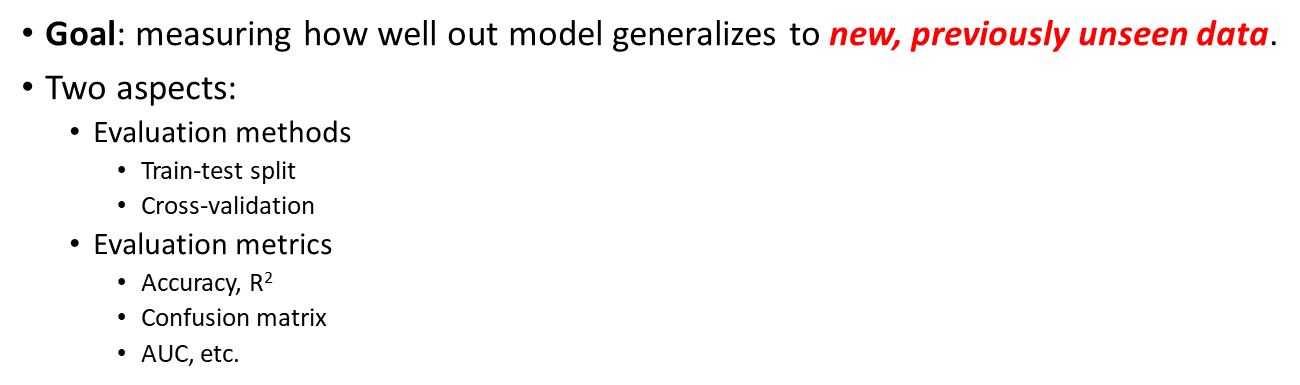

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.dummy import DummyClassifier

from sklearn.metrics import auc,precision_score, recall_score, f1_score,accuracy_score 
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

C:\Users\micha\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1. Cross Validation

### 1.1 Prepare data

In [2]:
churn = pd.read_csv('train_new_features_no_missing.csv')

In [3]:
churn.head()

,msno,is_churn,city,bd,gender,registered_via,registration_year,registration_month,registration_day,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,trans_year,trans_month,trans_day,trans_expiration_year,trans_expiration_month,trans_expiration_day,discount_value,discount_y,amount_per_day,day_from_last,trans_count,cancel_count,discount_freq,renew_freq,discount_std,cancel_freq,price_increase,num_100 size,num_100 mean,num_100 std,num_100 skew,num_25 mean,num_25 std,num_25 skew,num_50 mean,num_50 std,num_50 skew,num_75 mean,num_75 std,num_75 skew,num_985 mean,num_985 std,num_985 skew,num_unq mean,num_unq std,num_unq skew,total_song sum,total_song mean,total_song std,total_song skew,unique_song_ratio mean,unique_song_ratio std,unique_song_ratio skew,log_tot_sec mean,log_tot_sec std,log_tot_sec skew,100_to_total_song mean,100_to_total_song std,100_to_total_song skew,max_column c_mode,min_column c_mode,date interval_d,date n_in_last10d,bd_missing
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,True,18.0,36.0,female,9.0,2005.0,4.0,6.0,38,30,149,149,False,False,2017,1,7,2017,2,6,0,False,4.966667,52,2,0.0,0.000000,0.000000,0.000000,0.000000,4.966667,10.0,13.100000,9.073159,0.318105,1.7,2.162817,1.882936,0.2,0.421637,1.778781,0.5,0.707107,1.178511,0.3,0.483046,1.035098,14.703125,10.476562,0.282715,158.0,15.800000,10.674997,0.325558,0.913086,0.132690,-1.656250,7.865320,0.938542,-1.331009,0.795410,0.176514,-0.917969,num_100,num_50,1.6,0.0,False
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,True,10.0,38.0,male,9.0,2005.0,4.0,7.0,39,30,149,149,True,True,2017,2,24,2017,3,21,0,False,4.966667,4,23,2.0,0.043478,0.956522,31.068648,0.086957,0.000000,10.0,57.299999,79.940323,1.469861,2.5,3.308239,1.473018,1.1,1.286684,1.337917,0.4,0.699206,1.657725,0.7,1.059350,1.444002,29.906250,34.562500,0.000000,620.0,62.000000,84.654854,1.369632,0.709961,0.272217,-0.160767,7.947241,2.017965,0.019376,0.758789,0.325684,-1.695312,num_100,num_25,10.2,0.0,False
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,True,11.0,27.0,female,9.0,2005.0,10.0,16.0,39,30,149,149,True,True,2017,1,12,2017,2,3,0,False,4.966667,47,10,1.0,0.000000,0.800000,0.000000,0.100000,0.000000,10.0,17.000000,18.997076,0.863863,9.6,18.542444,2.875591,3.2,6.460134,2.824400,1.1,2.846050,2.910684,2.3,3.400980,2.242106,30.906250,39.875000,0.000000,332.0,33.200001,44.243771,2.140972,0.965332,0.066040,-1.984375,7.565980,1.665437,-0.352996,0.527832,0.316406,0.084595,num_100,num_75,3.9,0.0,False
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,True,13.0,23.0,female,9.0,2005.0,11.0,2.0,38,410,1788,1788,False,False,2016,1,6,2017,2,20,0,False,4.360976,419,2,0.0,0.000000,0.000000,0.000000,0.000000,4.360976,10.0,19.600000,7.589466,0.869489,9.8,7.223419,0.394974,3.8,3.084009,1.114810,4.0,2.748737,0.080251,2.4,1.837873,0.735618,29.796875,11.796875,-0.281006,396.0,39.599998,16.701298,-0.081119,0.774414,0.121277,0.669922,8.614584,0.431896,-1.151092,0.541504,0.171021,0.607422,num_100,num_985,1.0,3.0,False
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,True,3.0,27.0,male,9.0,2005.0,12.0,28.0,38,30,149,149,False,False,2017,1,28,2017,2,27,0,False,4.966667,31,8,0.0,0.000000,0.000000,0.000000,0.000000,0.382051,10.0,29.900000,34.459156,1.516453,2.3,3.335000,2.278980,0.6,1.074968,1.690570,0.2,0.421637,1.778781,0.6,0.699206,0.780106,33.312500,34.093750,0.000000,336.0,33.599998,34.338833,1.414105,0.993652,0.016617,-2.962891,8.355950,1.246466,-0.113503,0.812012,0.206299,-1.321289,num_100,num_25,1.2,8.0,False


** Dummy code categorical features **

In [4]:
churn = pd.get_dummies(churn ,
                       columns=['city','gender','registered_via','payment_method_id','max_column c_mode','min_column c_mode'])

In [5]:
churn.shape

(992931, 139)

** Shuffle the data **

In [6]:
churn = churn.sample(frac=1,random_state= 0 ).reset_index(drop=True)

In [7]:
churn.head()

,msno,is_churn,bd,registration_year,registration_month,registration_day,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,trans_year,trans_month,trans_day,trans_expiration_year,trans_expiration_month,trans_expiration_day,discount_value,discount_y,amount_per_day,day_from_last,trans_count,cancel_count,discount_freq,renew_freq,discount_std,cancel_freq,price_increase,num_100 size,num_100 mean,num_100 std,num_100 skew,num_25 mean,num_25 std,num_25 skew,num_50 mean,num_50 std,num_50 skew,num_75 mean,num_75 std,num_75 skew,num_985 mean,num_985 std,num_985 skew,num_unq mean,num_unq std,num_unq skew,total_song sum,total_song mean,total_song std,total_song skew,unique_song_ratio mean,unique_song_ratio std,unique_song_ratio skew,log_tot_sec mean,log_tot_sec std,log_tot_sec skew,100_to_total_song mean,100_to_total_song std,100_to_total_song skew,date interval_d,date n_in_last10d,bd_missing,city_0.0,city_1.0,city_3.0,city_4.0,city_5.0,city_6.0,city_7.0,city_8.0,city_9.0,city_10.0,city_11.0,city_12.0,city_13.0,city_14.0,city_15.0,city_16.0,city_17.0,city_18.0,city_19.0,city_20.0,city_21.0,city_22.0,gender_Unknown,gender_female,gender_male,registered_via_13.0,registered_via_3.0,registered_via_4.0,registered_via_7.0,registered_via_9.0,registered_via_Unknown,payment_method_id_3,payment_method_id_6,payment_method_id_8,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_40,payment_method_id_41,max_column c_mode_0,max_column c_mode_num_100,max_column c_mode_num_25,max_column c_mode_num_50,max_column c_mode_num_75,max_column c_mode_num_985,min_column c_mode_0,min_column c_mode_num_100,min_column c_mode_num_25,min_column c_mode_num_50,min_column c_mode_num_75,min_column c_mode_num_985
0,yQ1Vuk7eY1xYfH3RfpWH9kNHge/3svoZUJrIE3X8n0g=,False,29.0,2009.0,6.0,20.0,30,149,149,True,False,2017,1,31,2017,3,26,0,False,4.966667,28,19,1.0,0.052632,1.0,34.182944,0.052632,0.0,10.0,5.100000,4.433459,0.691591,3.1,4.012481,1.572733,1.2,1.619328,1.758420,0.5,0.707107,1.178511,0.9,1.197219,2.175585,8.000000,5.332031,0.280273,108.0,10.8,8.297256,0.714319,0.817871,0.184937,-0.156738,6.922534,1.170926,-0.741704,0.453369,0.265625,0.023224,2.8,0.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,UDkNk3peTC4h1GjPc4L6jfrE5g7zIok/8xo4l+jOl34=,False,36.0,2007.0,4.0,15.0,30,149,149,True,False,2017,2,28,2017,3,31,0,False,4.966667,0,22,0.0,0.272727,1.0,67.920504,0.000000,0.0,10.0,26.200001,21.611725,1.636924,10.9,10.795575,0.689682,2.4,3.062316,1.006347,0.6,0.843274,1.000564,1.4,2.118700,1.444002,25.093750,17.093750,0.910156,415.0,41.5,30.394627,0.839756,0.638184,0.174561,-0.612793,8.675392,0.648543,1.007449,0.689453,0.259033,-0.149536,1.0,10.0,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,jd65Fxpsab+p6Y6bkWr55Nu0rIW0HeC4TcxhzRPf61M=,False,0.0,2016.0,10.0,17.0,30,99,99,True,False,2017,2,16,2017,3,16,0,False,3.300000,12,5,0.0,0.000000,1.0,0.000000,0.000000,0.0,10.0,35.900002,42.435440,1.856771,4.6,4.168666,1.193136,1.6,2.270585,1.830950,0.7,1.159502,1.261585,0.2,0.421637,1.778781,36.312500,38.187500,0.000000,430.0,43.0,41.878132,1.720371,0.879883,0.177612,-1.370117,8.509616,1.002218,0.717694,0.749023,0.226562,-1.038086,1.4,6.0,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0

** Stratified sampling **

To save time in class demonstration

In [8]:
cols = [c for c in churn.columns if c not in ['is_churn','msno']]
X=churn[cols]
y=churn['is_churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.01,test_size=0.006, random_state= 0,stratify=y)

for d in [X_train, X_test, y_train, y_test]:
    print('The shape is {}'.format(d.shape))

print('y churn ratio is {:.2%}'.format(y.value_counts()[1]/y.shape[0]))
print('y_train churn ratio is {:.2%}'.format(y_train.value_counts()[1]/y_train.shape[0]))
print('y_test churn ratio is {:.2%}'.format(y_test.value_counts()[1]/y_test.shape[0]))


The shape is (9929, 137)
The shape is (5958, 137)
The shape is (9929,)
The shape is (5958,)
y churn ratio is 6.39%
y_train churn ratio is 6.40%
y_test churn ratio is 6.39%


### 1.2 Cross validation on training data

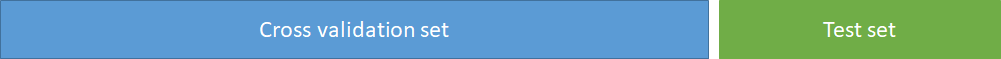

In [9]:
s=time.time()
clf_gbc=GBC(learning_rate=0.01, max_features=8,subsample=0.8,random_state=0,n_estimators = 400,max_depth=6,
           min_samples_leaf= 1, min_samples_split= 20)

cv_score = cross_val_score(clf_gbc, X_train, y_train, cv=5, scoring='accuracy',n_jobs=-1) # -1 is telling you to use all of your cores

clf_gbc.fit( X_train, y_train)

predprob_y=clf_gbc.predict_proba(X_train)
logloss_gbc=log_loss(y_train, predprob_y)

print('Model fitted in {:.2f} seconds.\n'.format(time.time()-s))
print('Cross-Validation Score: \nMean - {0:.5f} | Std - {1:.5f} | Min - {2:.5f} | Max - {3:.5f}'.format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
print('\ntraining accuracy is: {:.5f}'.format(clf_gbc.score( X_train, y_train)) )
print('\ntest accuracy is: {:.5f}'.format(clf_gbc.score( X_test, y_test)) )

Model fitted in 39.19 seconds.

Cross-Validation Score: 
Mean - 0.97019 | Std - 0.00392 | Min - 0.96324 | Max - 0.97481

training accuracy is: 0.98761

test accuracy is: 0.97029


### 1.3 Grid search with cross validation

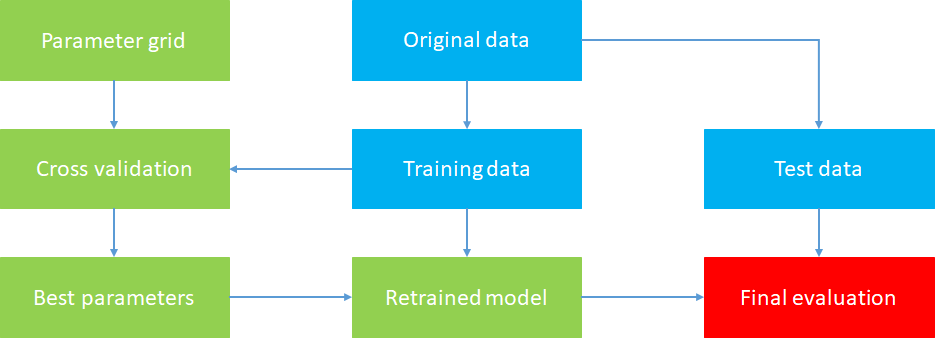

In [10]:
param_grid = {'max_depth':range(5,9),'min_samples_split': range(2,21,2)}
clf_grid = GridSearchCV(estimator = GBC(learning_rate=0.1, max_features='sqrt',subsample=0.8,random_state=0,n_estimators = 40), 
param_grid = param_grid, scoring='accuracy',n_jobs=-1,cv=5)

s=time.time()
clf_grid.fit(X_train, y_train)

print('Model fitted in {:.2f} seconds.\n'.format(time.time()-s))

#print('Grid search accuracy scores on training data:\n{}'.format(clf_grid.grid_scores_))

print('Grid search best parameters:\n{}\n'.format(clf_grid.best_params_))

print('Grid search best accuracy scores on training data:\n{:.4f}\n'.format(clf_grid.best_score_))

print('Training accuracy is {0:.5f} and test accuracy is {1:.5f}.\n'.format(
    clf_grid.score(X_train, y_train),clf_grid.score(X_test, y_test)))

cv_results=pd.DataFrame(clf_grid.grid_scores_)
cv_results

Model fitted in 79.29 seconds.

Grid search best parameters:
{'max_depth': 8, 'min_samples_split': 20}

Grid search best accuracy scores on training data:
0.9716

Training accuracy is 0.99214 and test accuracy is 0.97113.



C:\Users\micha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,parameters,mean_validation_score,cv_validation_scores
0,"{'max_depth': 5, 'min_samples_split': 2}",0.969282,"[0.9718026183282981, 0.9647532729103726, 0.969..."
1,"{'max_depth': 5, 'min_samples_split': 4}",0.968073,"[0.9707955689828801, 0.9652567975830816, 0.969..."
2,"{'max_depth': 5, 'min_samples_split': 6}",0.969483,"[0.9697885196374623, 0.9662638469284995, 0.969..."
3,"{'max_depth': 5, 'min_samples_split': 8}",0.969483,"[0.9712990936555891, 0.9662638469284995, 0.969..."
4,"{'max_depth': 5, 'min_samples_split': 10}",0.969383,"[0.9687814702920443, 0.9677744209466264, 0.969..."
5,"{'max_depth': 5, 'min_samples_split': 12}",0.970591,"[0.9718026183282981, 0.9687814702920443, 0.972..."
6,"{'max_depth': 5, 'min_samples_split': 14}",0.970289,"[0.972809667673716, 0.9662638469284995, 0.9702..."
7,"{'max_depth': 5, 'min_samples_split': 16}",0.969785,"[0.9707955689828801, 0.9642497482376636, 0.973..."
8,"{'max_depth': 5, 'min_samples_split': 18}",0.969886,"[0.9712990936555891, 0.9692849949647533, 0.968..."
9,"{'max_depth': 5, 'min_samples_split': 20}",0.969483,"[0.972809667673716, 0.9672708962739174, 0.9718..."


In [11]:
param_grid = {'max_features':range(8,60)}
clf_grid = GridSearchCV(estimator = GBC(learning_rate=0.1, max_depth=6,min_samples_split=18,
                                        subsample=0.8,random_state=0,n_estimators = 40), 
param_grid = param_grid, scoring='accuracy',n_jobs=-1,cv=5)

s=time.time()
clf_grid.fit(X_train, y_train)

print('Model fitted in {:.2f} seconds.\n'.format(time.time()-s))

#print('Grid search accuracy scores on training data:\n{}'.format(clf_grid.grid_scores_))

print('Grid search best parameters:\n{}\n'.format(clf_grid.best_params_))

print('Grid search best accuracy scores on training data:\n{:.4f}\n'.format(clf_grid.best_score_))

print('Training accuracy is {0:.5f} and test accuracy is {1:.5f}.\n'.format(
    clf_grid.score(X_train, y_train),clf_grid.score(X_test, y_test)))

cv_results=pd.DataFrame(clf_grid.cv_results_)  # grid_scores_


Model fitted in 115.80 seconds.

Grid search best parameters:
{'max_features': 41}

Grid search best accuracy scores on training data:
0.9730

Training accuracy is 0.99184 and test accuracy is 0.97029.



C:\Users\micha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\util

In [12]:
param_grid = {'max_features':range(8,60)}
clf_grid = GridSearchCV(estimator = GBC(learning_rate=0.1, max_depth=6,min_samples_split=18,
                                        subsample=0.8,random_state=0,n_estimators = 40), 
param_grid = param_grid, scoring='accuracy',n_jobs=-1,cv=5)

s=time.time()
clf_grid.fit(X_train, y_train)

print('Model fitted in {:.2f} seconds.\n'.format(time.time()-s))

#print('Grid search accuracy scores on training data:\n{}'.format(clf_grid.grid_scores_))

print('Grid search best parameters:\n{}\n'.format(clf_grid.best_params_))

print('Grid search best accuracy scores on training data:\n{:.4f}\n'.format(clf_grid.best_score_))

print('Training accuracy is {0:.5f} and test accuracy is {1:.5f}.\n'.format(
    clf_grid.score(X_train, y_train),clf_grid.score(X_test, y_test)))

cv_results=pd.DataFrame(clf_grid.grid_scores_)  # 

Model fitted in 114.84 seconds.

Grid search best parameters:
{'max_features': 41}

Grid search best accuracy scores on training data:
0.9730

Training accuracy is 0.99184 and test accuracy is 0.97029.



C:\Users\micha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [13]:
param_grid = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9,0.95]}
clf_grid = GridSearchCV(estimator = GBC(learning_rate=0.1, max_depth=6,min_samples_split=18,max_features=36,
                                        random_state=0,n_estimators = 40), 
param_grid = param_grid, scoring='accuracy',n_jobs=-1,cv=5)

s=time.time()
clf_grid.fit(X_train, y_train)

print('Model fitted in {:.2f} seconds.\n'.format(time.time()-s))

#print('Grid search accuracy scores on training data:\n{}'.format(clf_grid.grid_scores_))

print('Grid search best parameters:\n{}\n'.format(clf_grid.best_params_))

print('Grid search best accuracy scores on training data:\n{:.4f}\n'.format(clf_grid.best_score_))

print('Training accuracy is {0:.5f} and test accuracy is {1:.5f}.\n'.format(
    clf_grid.score(X_train, y_train),clf_grid.score(X_test, y_test)))

#cv_results=pd.DataFrame(clf_grid.grid_scores_)

Model fitted in 48.13 seconds.

Grid search best parameters:
{'subsample': 0.75}

Grid search best accuracy scores on training data:
0.9719

Training accuracy is 0.99023 and test accuracy is 0.97231.



#### Use tuned parameters for last cross validation

In [14]:
s=time.time()
clf_gbc=GBC(learning_rate=0.01, max_features=36,subsample=0.8,random_state=0,n_estimators = 400,max_depth=6,
           min_samples_split= 18)

cv_score = cross_val_score(clf_gbc, X_train, y_train, cv=5, scoring='accuracy',n_jobs=-1)

clf_gbc.fit( X_train, y_train)

predprob_y=clf_gbc.predict_proba(X_train)
logloss_gbc=log_loss(y_train, predprob_y)

print('Model fitted in {:.2f} seconds.\n'.format(time.time()-s))
print('Cross-Validation Score: \nMean - {0:.5f} | Std - {1:.5f} | Min - {2:.5f} | Max - {3:.5f}'.format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
print('\ntraining accuracy is: {:.5f}'.format(clf_gbc.score( X_train, y_train)) )
print('\ntest accuracy is: {:.5f}'.format(clf_gbc.score( X_test, y_test)) )

Model fitted in 53.90 seconds.

Cross-Validation Score: 
Mean - 0.97200 | Std - 0.00436 | Min - 0.96475 | Max - 0.97633

training accuracy is: 0.99174

test accuracy is: 0.97080


## 2. Evaluation Metrics

### 2.1 Dummy Classifier

DummyClassifier is a classifier that makes predictions using simple rules, which can be useful as a baseline for comparison against actual classifiers, especially with **imbalanced** classes.

In [15]:
# is_churn Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)

In [16]:
dummy_majority.score(X_test, y_test)

0.9360523665659617

### 2.2 Confusion Marrix

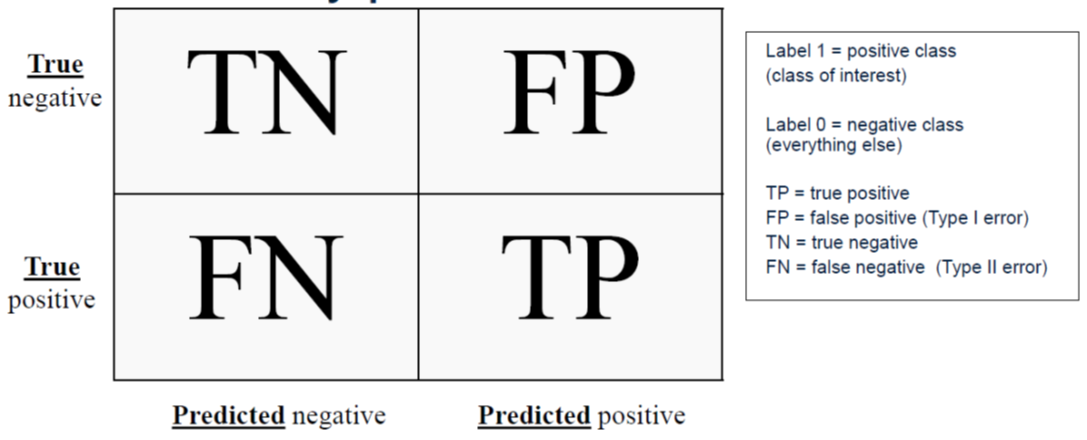

Confusion matrix of dummy classifier

In [17]:
y_majority_predicted = dummy_majority.predict(X_test)
confusion = confusion_matrix(y_test, y_majority_predicted)

Text(0.5,15,'Predicted label')

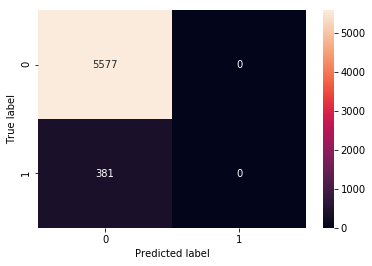

In [18]:
sns.heatmap(confusion,annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

Confusion matrix of GBC

Text(0.5,15,'Predicted label')

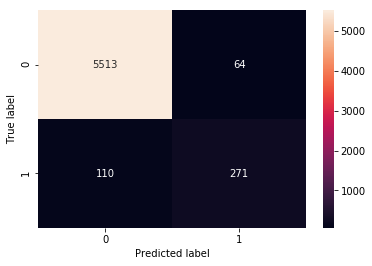

In [19]:
confusion = confusion_matrix(y_test,clf_gbc.predict(X_test))
sns.heatmap(confusion,annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 2.3 Precision, Recall, accuracy, F1
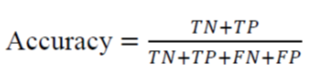


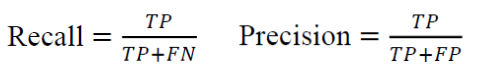

In [20]:
(282+5512)/(5512+65+99+282), 282/(282+99),282/(282+65)

(0.9724739845585767, 0.7401574803149606, 0.8126801152737753)

In [21]:
pred_y=clf_gbc.predict(X_test)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, pred_y)))
print('Precision: {:.2f}'.format(precision_score(y_test, pred_y)))
print('Recall: {:.2f}'.format(recall_score(y_test, pred_y)))
print('F1: {:.2f}'.format(f1_score(y_test, pred_y)))

Accuracy: 0.97
Precision: 0.81
Recall: 0.71
F1: 0.76


### 2.4 Classification report

In [22]:
print(classification_report(y_test, pred_y,target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98      5577
          1       0.81      0.71      0.76       381

avg / total       0.97      0.97      0.97      5958



### 2.5 Log loss

In [23]:
predprob_y_test=clf_gbc.predict_proba(X_test)
logloss_gbc_test=log_loss(y_test, predprob_y_test)

predprob_y_train=clf_gbc.predict_proba(X_train)
logloss_gbc_train=log_loss(y_train, predprob_y_train)

print('Log loss on train data is: ',logloss_gbc_train)
print('Log loss on test data is: ',logloss_gbc_test)

Log loss on train data is:  0.03820176743331416
Log loss on test data is:  0.07183989200463307


### 2.6 ROC AUC

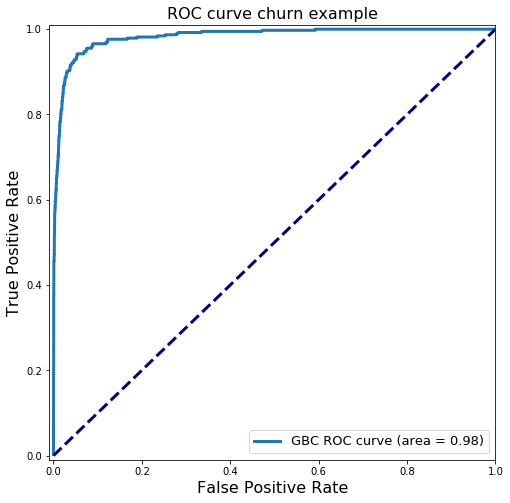

In [24]:
y_score_lr = clf_gbc.decision_function(X_test)
fpr_lr, tpr_lr, th = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='GBC ROC curve (area = {:0.2f})'.format(roc_auc_lr))

plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve churn example', fontsize=16)
plt.legend(loc='lower right', fontsize=13)

plt.show()